# Week 2: Predicting time series

Welcome! In the previous assignment you got some exposure to working with time series data, but you didn't use machine learning techniques for your forecasts. This week you will be using a deep neural network to create one step forecasts to see how this technique compares with the ones you already tried out. Once again all of the data is going to be generated.

#### TIPS FOR SUCCESSFUL GRADING OF YOUR ASSIGNMENT:

- All cells are frozen except for the ones where you need to submit your solutions or when explicitly mentioned you can interact with it.

- You can add new cells to experiment but these will be omitted by the grader, so don't rely on newly created cells to host your solution code, use the provided places for this.

- You can add the comment # grade-up-to-here in any graded cell to signal the grader that it must only evaluate up to that point. This is helpful if you want to check if you are on the right track even if you are not done with the whole assignment. Be sure to remember to delete the comment afterwards!

- Avoid using global variables unless you absolutely have to. The grader tests your code in an isolated environment without running all cells from the top. As a result, global variables may be unavailable when scoring your submission. Global variables that are meant to be used will be defined in UPPERCASE.

- To submit your notebook, save it and then click on the blue submit button at the beginning of the page.

Let's get started!

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2024-10-03 14:11:22.948349: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-03 14:11:22.956279: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-03 14:11:22.965222: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-03 14:11:22.967860: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-03 14:11:22.974829: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import unittests

## Generating the data

First things first, you will need to generate your time series data. 

The next cell includes a bunch of helper functions to generate and plot the time series. These are very similar to those you saw on Week 1.

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    """A trend over time"""
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi), 
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    """Adds noise to the series"""
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

Now, define a function to generate the time series, using the functions from the previous cell. This function should return a time series that has trend, seasonality and noise. 

In [4]:
def generate_time_series():
    """ Creates timestamps and values of the time series """
    
    # The time dimension or the x-coordinate of the time series
    time = np.arange(4 * 365 + 1, dtype="float32")

    # Initial series is just a straight line with a y-intercept
    y_intercept = 10
    slope = 0.005
    series = trend(time, slope) + y_intercept

    # Adding seasonality
    amplitude = 50
    series += seasonality(time, period=365, amplitude=amplitude)

    # Adding some noise
    noise_level = 3
    series += noise(time, noise_level, seed=51)
    
    return time, series

## Defining some useful global variables

Next, you will define some global variables that will be used throughout the assignment. Feel free to reference them in the upcoming exercises:

`SPLIT_TIME`: time index to split between train and validation sets

`WINDOW_SIZE`: length of the window to use for smoothing the series

`BATCH_SIZE`: batch size for training the model

`SHUFFLE_BUFFER_SIZE`: number of elements from the dataset used to sample for a new shuffle of the dataset. For more information about the use of this variable you can take a look at the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle).

**A note about grading:**

**When you submit this assignment for grading these same values for these globals will be used so make sure that all your code works well with these values. After submitting and passing this assignment, you are encouraged to come back here and play with these parameters to see the impact they have in the classification process. Since this next cell is frozen, you will need to copy the contents into a new cell and run it to overwrite the values for these globals.**


In [5]:
# Save all global variables
SPLIT_TIME = 1100
WINDOW_SIZE = 20
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

Finally, put everything together and create the times series you will use for this assignment. 

In [6]:
# Create the time series
TIME, SERIES = generate_time_series()

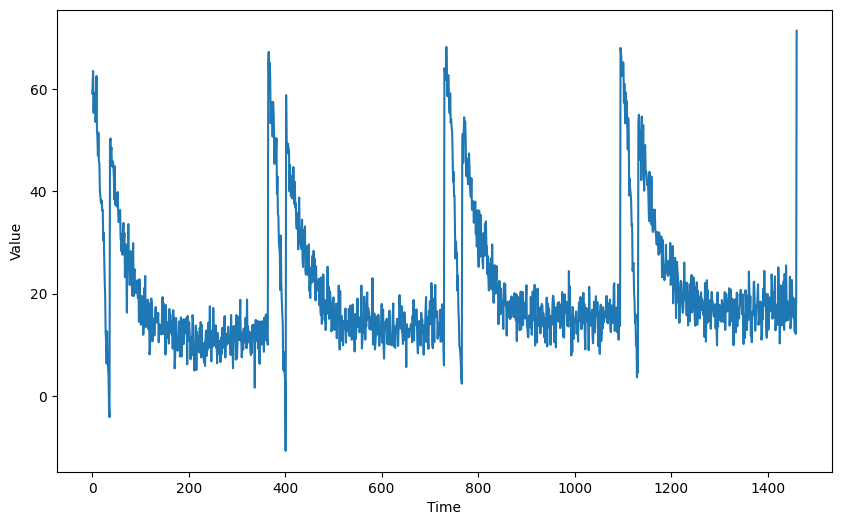

In [7]:
# Plot the generated series
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

## Splitting the data

As usual, you will need a function to split the data between train and validation sets. Since you already coded the `train_val_split` function during last week's assignment, this time it is provided for you:

In [8]:
def train_val_split(time, series):

    time_train = time[:SPLIT_TIME]
    series_train = series[:SPLIT_TIME]
    time_valid = time[SPLIT_TIME:]
    series_valid = series[SPLIT_TIME:]

    return time_train, series_train, time_valid, series_valid


# Split the dataset
time_train, series_train, time_valid, series_valid = train_val_split(TIME, SERIES)

## Processing the data

### Exercise 1: windowed_dataset

As you saw on the lectures, you can feed the data for training by creating a TF Dataset with the appropriate processing steps such as `windowing`, `flattening`, `batching` and `shuffling`. Remember you can do all these using the different methods of the `tf.data.Dataset` object. Next, complete the `windowed_dataset` function below that effectively pre-processes your time series and returns a TF Dataset.

This function receives a `series` and a `window_size`, and returns a TF Dataset. You should already be familiar with `tf.data.Dataset` objects from the this week's lectures, but be sure to check out the [docs](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) if you need any help.

In [15]:
# GRADED FUNCTION: windowed_dataset
def windowed_dataset(series, window_size, shuffle=True):
    """Create a windowed dataset

    Args:
        series (np.ndarray): time series
        window_size (int): length of window to use for prediction
        shuffle (bool): (For testing purposes) Indicates whether to shuffle data before batching or not. Defaults to True

    Returns:
        td.data.Dataset: windowed dataset
    """
    
    ### START CODE HERE ###
    # Create dataset from the series. 
    # HINT: use an appropriate method from the tf.data.Dataset object
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Slice the dataset into the appropriate windows
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the dataset
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Shuffle it
    if shuffle:  # For testing purposes
        dataset = dataset.shuffle(SHUFFLE_BUFFER_SIZE)
    
    # Split it into the features and labels. 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    
    # Batch it
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    
    ### END CODE HERE ###
    
    return dataset

To test your function you will be using a `window_size` of 10 which means that you will use 10 consecutive values to predict the next one. You will also set the parameter `shuffle=False`. Given this, the first element of the batch of features should be identical to the first 15 elements of the `series_train`, and the batch of labels should be equal to elements 10 through 42 of the `series_train`.

In [16]:
# Try out your function with windows size of 1 and no shuffling
test_dataset = windowed_dataset(series_train, window_size=10,shuffle= False)

# Get the first batch of the test dataset
batch_of_features, batch_of_labels = next((iter(test_dataset)))

print(f"batch_of_features has type: {type(batch_of_features)}\n")
print(f"batch_of_labels has type: {type(batch_of_labels)}\n")
print(f"batch_of_features has shape: {batch_of_features.shape}\n")
print(f"batch_of_labels has shape: {batch_of_labels.shape}\n")
print(f"First element in batch_of_features is equal to first 10 elements in the series: {np.allclose(batch_of_features.numpy()[0].flatten(), series_train[:10])}\n")
print(f"batch_of_labels is equal to the first 32 values after the window_lenght of 10): {np.allclose(batch_of_labels.numpy(), series_train[10:BATCH_SIZE+10])}")

batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (32, 10)

batch_of_labels has shape: (32,)

First element in batch_of_features is equal to first 10 elements in the series: True

batch_of_labels is equal to the first 32 values after the window_lenght of 10): True


**Expected Output:**

```
batch_of_features has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_labels has type: <class 'tensorflow.python.framework.ops.EagerTensor'>

batch_of_features has shape: (32, 10)

batch_of_labels has shape: (32,)

First element in batch_of_features is equal to first 10 elements in the series: True

batch_of_labels is equal to the first 32 values after the window_lenght of 10): True
```

Now plot the first item in the batch. You will be displayng the 20 features, followed by the label, which is the value you want to predict. 

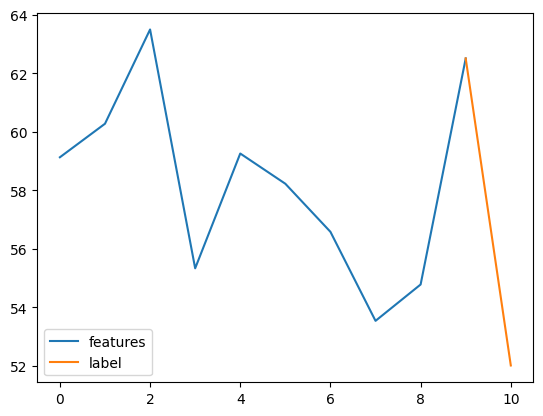

In [17]:
plt.plot(np.arange(10), batch_of_features[0].numpy(), label='features')
plt.plot(np.arange(9,11), [batch_of_features[0].numpy()[-1], batch_of_labels[0].numpy()], label='label');
plt.legend()

Now that you have tested your `windowed_dataset` function, use it to create your train dataset. For that, just run the cell below

In [18]:
# Apply the processing to the whole training series
train_dataset = windowed_dataset(series_train, WINDOW_SIZE)

In [19]:
# Test your code!
unittests.test_windowed_dataset(windowed_dataset)

 All tests passed!


## Defining the model architecture

### Exercise 2: create_model 

Now that you have a function that will process the data before it is fed into your neural network for training, it is time to define you model architecture.

Complete the `create_model` function below. Notice that this function receives the `window_size` since this will be an important parameter for the first layer of your network.

Remember that this time you are predicting the values of a time series, so use an appropriate loss for this task. There are many you can choose for, but for grading purposes, please stick to 'mse'. 

Hint:
- You will only need `Dense` layers.
- The training should be really quick so if you notice that each epoch is taking more than a few seconds, consider trying a different architecture.



In [20]:
# GRADED FUNCTION: create_model
def create_model(window_size):
    """Create model for predictions
    Args:
        window_size (int): length of window to use for prediction

    Returns:
        tf.keras.Model: model
    """
    ### START CODE HERE ###

    model = tf.keras.models.Sequential([ 
        # Input layer
        tf.keras.Input(shape=(window_size,)),  # Input shape is the window size
        
        # Hidden Dense layer(s)
        tf.keras.layers.Dense(128, activation='relu'),  # Hidden layer with 128 units
        tf.keras.layers.Dense(64, activation='relu'),   # Hidden layer with 64 units
        
        # Output layer (1 unit for predicting the next value)
        tf.keras.layers.Dense(1)  # Output layer with 1 unit (since we're predicting 1 value)
    ]) 

    # Compile the model
    model.compile(
        loss='mse',  # Mean squared error loss for regression
        optimizer=tf.keras.optimizers.Adam(),  # Adam optimizer
        metrics=['mae']  # Mean absolute error for evaluation
    )
    
    ### END CODE HERE ###

    return model

The next cell allows you to check the number of total and trainable parameters of your model and prompts a warning in case these exceeds those of a reference solution, this serves the following 3 purposes listed in order of priority:

- Helps you prevent crashing the kernel during training.

- Helps you avoid longer-than-necessary training times.

- Provides a reasonable estimate of the size of your model. In general you will usually prefer smaller models given that they accomplish their goal successfully.

**Notice that this is just informative** and may be very well below the actual limit for size of the model necessary to crash the kernel. So even if you exceed this reference you are probably fine. However, **if the kernel crashes during training or it is taking a very long time and your model is larger than the reference, come back here and try to get the number of parameters closer to the reference.**

In [21]:
# Get the untrained model
model = create_model(WINDOW_SIZE)

# Check the parameter count against a reference solution
unittests.parameter_count(model)

Your model has 11,009 total parameters and the reference is 3,200
Warning! this exceeds the reference which is 3,200. If the kernel crashes while training, switch to a simpler architecture.

Your model has 11,009 trainable parameters and the reference is 3,200
Warning! this exceeds the reference which is 3,200. If the kernel crashes while training, switch to a simpler architecture.


In [22]:
example_batch = train_dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

I0000 00:00:1728048286.025023 2268566 service.cc:146] XLA service 0x7ae13c0058a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728048286.025046 2268566 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-04 06:24:46.030759: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 06:24:46.052173: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-04 06:24:46.065462: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

predictions have shape: (32, 1)


I0000 00:00:1728048286.406533 2268566 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-10-04 06:24:46.408551: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 06:24:46.408584: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-10-04 06:24:46.408594: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:24:46.408605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
/home/codingfreak/anaconda3/envs/tf-gpu/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that

**Expected output:**
```
predictions have shape: (NUM_BATCHES, 1)

Where NUM_BATCHES is the number of batches you have set to your dataset.
```

Before going any further, check that the input and output dimensions of your model are correct. Do this by running the cell below:

In [23]:
print(f'Model input shape: {model.input_shape}')
print(f'Model output shape: {model.output_shape}')

Model input shape: (None, 20)
Model output shape: (None, 1)


You can also print a summary of your model to see what the architecture looks like. 

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,009 (43.00 KB)

 Trainable params: 11,009 (43.00 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Test your code!
unittests.test_create_model(create_model, windowed_dataset)

2024-10-04 06:25:40.144092: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_319', 8 bytes spill stores, 8 bytes spill loads



 All tests passed!


2024-10-04 06:25:40.421864: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 06:25:40.421931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:40.421956: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006


In [26]:
# Train it
history = model.fit(train_dataset, epochs=100)

Epoch 1/100


2024-10-04 06:25:40.973829: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_316', 8 bytes spill stores, 8 bytes spill loads



34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 104.3115 - mae: 6.3267
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - loss: 34.2445 - mae: 3.4257
Epoch 3/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 502us/step - loss: 32.5517 - mae: 3.4819
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 23.6969 - mae: 3.0858
Epoch 5/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 15.7349 - mae: 2.8455

2024-10-04 06:25:41.860801: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:41.860834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:41.914939: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 06:25:41.914963: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:41.970888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:41.970926: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:42.018908: I tensorflow/core/framework/local_rendezv

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step - loss: 23.4501 - mae: 3.1279
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 28.1942 - mae: 3.1105
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 466us/step - loss: 18.4885 - mae: 2.8138
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 26.3978 - mae: 3.0992
Epoch 9/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 13.4454 - mae: 3.0857

2024-10-04 06:25:42.066317: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.066338: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:42.116194: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 06:25:42.116216: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.116222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:42.215869: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.215911: I tensorflow/core/framework/local_rendez

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step - loss: 21.9590 - mae: 3.0437
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 25.4020 - mae: 2.9646
Epoch 11/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 22.3423 - mae: 2.9959
Epoch 12/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 19.3669 - mae: 2.7940
Epoch 13/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 91.9657 - mae: 4.1119

2024-10-04 06:25:42.274845: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.274880: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:42.339231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.339258: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:42.390276: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.390296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:42.435595: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 34.3467 - mae: 3.1873
Epoch 14/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - loss: 21.6869 - mae: 2.8461
Epoch 15/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 29.7167 - mae: 3.1944
Epoch 16/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 20.4019 - mae: 2.9556
Epoch 17/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 7.8734 - mae: 2.3298

2024-10-04 06:25:42.483008: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.483028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:42.536760: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 06:25:42.536783: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.536791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:42.595946: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.595967: I tensorflow/core/framework/local_rendez

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 565us/step - loss: 22.4734 - mae: 2.8569
Epoch 18/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step - loss: 26.5286 - mae: 2.9380
Epoch 19/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 555us/step - loss: 23.0040 - mae: 2.6839
Epoch 20/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - loss: 20.5777 - mae: 2.9023
Epoch 21/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 97.6954 - mae: 4.2125

2024-10-04 06:25:42.695239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.695264: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:42.751947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.751968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:42.807138: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.807161: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:42.853707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 27.2869 - mae: 3.0019
Epoch 22/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step - loss: 26.4227 - mae: 2.9192
Epoch 23/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 24.9344 - mae: 2.8507
Epoch 24/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - loss: 20.8696 - mae: 2.8748
Epoch 25/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 11.9052 - mae: 2.9353

2024-10-04 06:25:42.900200: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.900221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:42.945285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:42.945318: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:43.063191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.063213: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 22.2232 - mae: 2.8302
Epoch 26/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 20.0474 - mae: 2.7481
Epoch 27/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step - loss: 18.4600 - mae: 2.7080
Epoch 28/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 20.6760 - mae: 2.8626
Epoch 29/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 6.5949 - mae: 2.1362

2024-10-04 06:25:43.112304: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.112325: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:43.159373: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.159394: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:43.218006: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.218026: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:43.312517: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 498us/step - loss: 20.6376 - mae: 2.8614
Epoch 30/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 445us/step - loss: 17.0249 - mae: 2.6750
Epoch 31/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 22.6633 - mae: 2.7574
Epoch 32/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 479us/step - loss: 15.5666 - mae: 2.5958
Epoch 33/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 533us/step - loss: 22.3292 - mae: 2.7596
Epoch 34/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 13.9837 - mae: 2.5440

2024-10-04 06:25:43.359484: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 06:25:43.359511: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.359517: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:43.416448: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.416468: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:43.467596: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.467619: I tensorflow/core/framework/local_rendez

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 582us/step - loss: 21.2674 - mae: 2.7153
Epoch 35/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 594us/step - loss: 14.9423 - mae: 2.5981
Epoch 36/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 16.3816 - mae: 2.7085
Epoch 37/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - loss: 22.4411 - mae: 2.8238
Epoch 38/100


2024-10-04 06:25:43.568548: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.568584: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:43.621174: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.621209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:43.681444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.681469: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:43.735635: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step - loss: 25.5535 - mae: 2.8151
Epoch 39/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 18.7538 - mae: 2.6183
Epoch 40/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step - loss: 25.2293 - mae: 2.8667
Epoch 41/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step - loss: 23.7254 - mae: 2.8262
Epoch 42/100


2024-10-04 06:25:43.801120: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.801142: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:43.847981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.848000: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:43.895707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:43.895729: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:43.968364: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 13.5768 - mae: 2.6096
Epoch 43/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 521us/step - loss: 19.8138 - mae: 2.7991
Epoch 44/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 15.6081 - mae: 2.6324
Epoch 45/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 472us/step - loss: 14.0023 - mae: 2.4586
Epoch 46/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 14.3165 - mae: 2.7860

2024-10-04 06:25:44.019974: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:44.019997: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:44.067541: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:44.067563: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:44.119962: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:44.119983: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:44.168781: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 527us/step - loss: 15.2718 - mae: 2.7572
Epoch 47/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 15.8070 - mae: 2.6525
Epoch 48/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 15.0181 - mae: 2.6390
Epoch 49/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step - loss: 22.8223 - mae: 2.7234
Epoch 50/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 10.9794 - mae: 2.6076

2024-10-04 06:25:44.225810: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:44.225847: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:44.276176: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:44.337500: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:44.337539: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:44.384981: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:44.385016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 20.3992 - mae: 2.6527
Epoch 51/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step - loss: 14.7819 - mae: 2.5094
Epoch 52/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 17.8617 - mae: 2.6656
Epoch 53/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - loss: 22.7095 - mae: 2.7241
Epoch 54/100


2024-10-04 06:25:44.434707: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:44.486789: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:44.486824: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:44.538475: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:44.538510: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:44.600968: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 17.6750 - mae: 2.6759
Epoch 55/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step - loss: 20.9836 - mae: 2.7543
Epoch 56/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step - loss: 16.4741 - mae: 2.6213
Epoch 57/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 20.8367 - mae: 2.6622
Epoch 58/100


2024-10-04 06:25:44.655324: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:44.655359: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:44.705821: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:44.769165: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:44.769191: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 18.0528 - mae: 2.6543
Epoch 59/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step - loss: 15.4274 - mae: 2.5105
Epoch 60/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - loss: 17.5982 - mae: 2.6305
Epoch 61/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 18.4863 - mae: 2.6426
Epoch 62/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 72.7519 - mae: 3.4868

2024-10-04 06:25:44.906354: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:44.906377: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:44.955239: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:44.955265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.013755: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:45.013775: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.059957: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 20.7365 - mae: 2.6390
Epoch 63/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - loss: 22.8158 - mae: 2.7212
Epoch 64/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 11.9791 - mae: 2.5594
Epoch 65/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 19.6584 - mae: 2.7018
Epoch 66/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 12.0818 - mae: 2.4368

2024-10-04 06:25:45.121741: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-04 06:25:45.121777: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.171015: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:45.171048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.230020: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:45.230056: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.278038: I tensorflow/core/framework/local_rendezv

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - loss: 20.1159 - mae: 2.7347
Epoch 67/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step - loss: 18.5917 - mae: 2.5604
Epoch 68/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step - loss: 24.9913 - mae: 2.8318
Epoch 69/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 523us/step - loss: 17.8190 - mae: 2.6191
Epoch 70/100


2024-10-04 06:25:45.336426: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:45.336471: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.396819: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:45.396842: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.446912: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:45.446935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.504188: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 14.7128 - mae: 2.5714
Epoch 71/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 672us/step - loss: 17.3491 - mae: 2.6082
Epoch 72/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 11.4344 - mae: 2.3828
Epoch 73/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 16.2547 - mae: 2.6425
Epoch 74/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 9.0048 - mae: 2.3197

2024-10-04 06:25:45.584153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.639688: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:45.639716: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.693675: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:45.693696: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.739630: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:45.739652: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 13.4400 - mae: 2.5195
Epoch 75/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 487us/step - loss: 14.1092 - mae: 2.4908
Epoch 76/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 470us/step - loss: 18.9201 - mae: 2.6500
Epoch 77/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 441us/step - loss: 17.8371 - mae: 2.6382
Epoch 78/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 14.2388 - mae: 2.5103
Epoch 79/100


2024-10-04 06:25:45.790395: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:45.790413: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.845924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:45.845945: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.893100: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:45.893121: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:45.942822: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 465us/step - loss: 16.6922 - mae: 2.5111
Epoch 80/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 14.5155 - mae: 2.6184
Epoch 81/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 562us/step - loss: 15.4581 - mae: 2.6887
Epoch 82/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - loss: 14.1288 - mae: 2.4975
Epoch 83/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.1625 - mae: 2.1441

2024-10-04 06:25:46.040549: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.040571: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:46.091072: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.091094: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:46.144823: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.144849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:46.202102: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 547us/step - loss: 14.1406 - mae: 2.5284
Epoch 84/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - loss: 16.8759 - mae: 2.5592
Epoch 85/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step - loss: 17.0472 - mae: 2.6660
Epoch 86/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step - loss: 11.3101 - mae: 2.3779
Epoch 87/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - loss: 13.8220 - mae: 2.4408
Epoch 88/100


2024-10-04 06:25:46.249950: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.249970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:46.295112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.295134: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:46.342648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.342669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:46.394983: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 501us/step - loss: 17.6870 - mae: 2.6042
Epoch 89/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 14.1760 - mae: 2.3827
Epoch 90/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - loss: 12.4787 - mae: 2.4289
Epoch 91/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 474us/step - loss: 19.5718 - mae: 2.6245
Epoch 92/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 6.1790 - mae: 2.0978

2024-10-04 06:25:46.493464: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.493486: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:46.546928: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.546951: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:46.593331: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:46.644716: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.644737: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - loss: 13.9958 - mae: 2.4446
Epoch 93/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 526us/step - loss: 12.7761 - mae: 2.3480
Epoch 94/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - loss: 10.7267 - mae: 2.3567
Epoch 95/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step - loss: 16.4545 - mae: 2.6792
Epoch 96/100
 1/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 7.8782 - mae: 2.1395

2024-10-04 06:25:46.695815: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.695834: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:46.754732: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.754753: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:46.809423: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.809445: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:46.857883: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 16.8510 - mae: 2.4994
Epoch 97/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - loss: 14.1075 - mae: 2.7112
Epoch 98/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 457us/step - loss: 18.1910 - mae: 2.7304
Epoch 99/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step - loss: 16.6943 - mae: 2.5771
Epoch 100/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step - loss: 12.2306 - mae: 2.2933


2024-10-04 06:25:46.965761: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:46.965791: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:47.020597: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:47.020618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:47.070223: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10432743282938319535
2024-10-04 06:25:47.070268: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 1008406120899935006
2024-10-04 06:25:47.126026: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 

Now go ahead and plot the training loss so you can monitor the learning process.

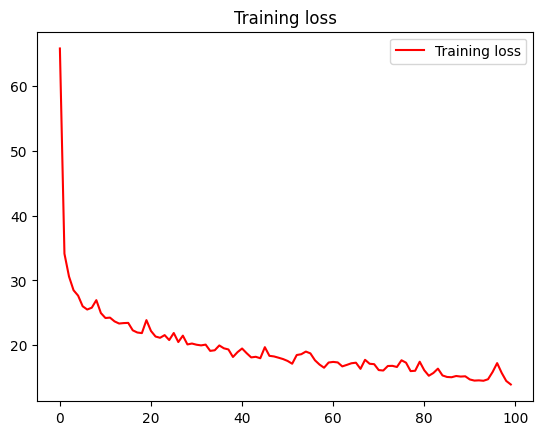

In [27]:
# Plot the training loss for each epoch

loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.show()

## Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this you can use the `compute_metrics` function that you coded in the previous assignment:

In [28]:
def compute_metrics(true_series, forecast):
    mse = tf.keras.losses.MSE(true_series, forecast)
    mae = tf.keras.losses.MAE(true_series, forecast)
    return mse, mae

You will also be generating `predict_forecast` function, that simply computes predictions for all values in the validation data. 

In [29]:
def generate_forecast(model, series, window_size):
    forecast = []
    for time in range(SPLIT_TIME, len(series)):
        pred = model.predict(series[time-window_size:time][np.newaxis], verbose=0)
        forecast.append(pred[0][0])
    return forecast

Now, go ahead and make the predictions. This run should take no more time than the actual training.  

In [30]:
# Save the forecast
dnn_forecast = generate_forecast(model, SERIES, WINDOW_SIZE)

You can now plot the true series, and the predicted series in order to get a visual estimate of how good your model is doing.

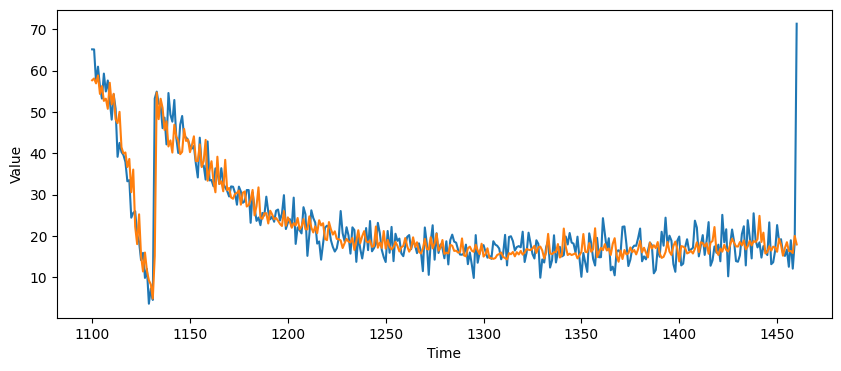

In [31]:
# Plot it
plt.figure(figsize=(10, 4))
plot_series(time_valid, series_valid)
plot_series(time_valid, dnn_forecast)

**Expected Output:**

A series similar to this one:

<div>
<img src="images/forecast.png" width="800">
</div>

Finally, go ahead and compute the MSE and MAE metrics using the `compute_metrics` function you defined earlier.

In [32]:
mse, mae = compute_metrics(series_valid, dnn_forecast)

print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 25.98, mae: 3.25 for forecast


**To pass this assignment your forecast should achieve an MSE of 30 or less.**

- If your forecast didn't achieve this threshold try re-training your model with a different architecture or tweaking the optimizer's parameters.


- If your forecast did achieve this threshold run the following cell to save the MSE in a binary file which will be used for grading and after doing so, submit your assigment for grading.

In [33]:
# ONLY RUN THIS CELL IF YOUR MSE ACHIEVED THE DESIRED MSE LEVEL
# Save your model 
model.save('trained_model.keras')

**Congratulations on finishing this week's assignment!**

You have successfully implemented a neural network capable of forecasting time series while also learning how to leverage Tensorflow's Dataset class to process time series data!

**Keep it up!**